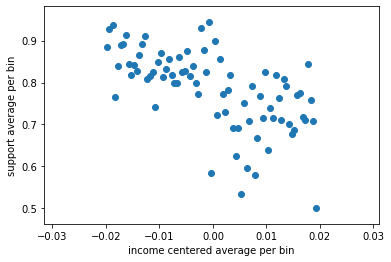

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

uruguay = pd.read_csv("~/csv/transfers_uruguay.csv")

inc_bin_low, inc_bin_high = uruguay['inc_centered'].min(), uruguay['inc_centered'].max()
interval_width = 0.0005

bin_edges = np.arange(inc_bin_low, inc_bin_high, interval_width)
uruguay['inc_centered_bin'] = pd.cut(uruguay['inc_centered'], bin_edges)

avg_supp_per_inc = uruguay.groupby(['inc_centered_bin'])['inc_centered','gov_support'].mean().dropna()

plt.scatter(avg_supp_per_inc.inc_centered, avg_supp_per_inc.gov_support)
plt.xlabel("income centered average per bin")
plt.ylabel("support average per bin") 
plt.show()


1. Observations
For one, there seems to be a negative relationship between income and government support. Secondly, the graph shows a discontinuity in the relationship between inc_centered and gov_support at the approximate inc_centered value of 0.0 (which reflects Uruguay's average income).

2. Necessary Assumptions of Regression Discontinuity Designs in Order to Interpret Results Causally
?
In order to use regression discontinuity techniques to estimate the effect of government transfers on income, we would have to assume that absent from the treatment, income, government support is continuous and that there is no other x-variable which causes the discontinuity. If this is the case, we know that the running variable, income, is causing the discontinuity in government support.C

In [13]:
import statsmodels.formula.api as smf

inc_above_mean_df = uruguay[uruguay["inc_centered"] > 0]
inc_below_mean_df = uruguay[uruguay['inc_centered'] <= 0]

results = smf.ols('gov_support ~ inc_centered', data=inc_above_mean_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            gov_support   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.007110
Date:                Wed, 01 May 2024   Prob (F-statistic):              0.933
Time:                        11:32:23   Log-Likelihood:                -296.19
No. Observations:                 821   AIC:                             596.4
Df Residuals:                     819   BIC:                             605.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7296      0.025     29.149      0.000       0.680       0.779
inc_centered    -0.1794      2.128     -0.084      0.933      -4.356       3.998
==============================================================================
Omnibus:                       95.240   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.674
Skew:                          -0.889   Prob(JB):                     7.62e-26
Kurtosis:                       2.534   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
at_cutoff = pd.Series([0], name = 'inc_centered')
results.predict(at_cutoff)

0    0.729617
dtype: float64

In [18]:
results2 = smf.ols('gov_support ~ inc_centered', data=inc_below_mean_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            gov_support   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.190
Date:                Wed, 01 May 2024   Prob (F-statistic):              0.275
Time:                        11:36:51   Log-Likelihood:                -183.86
No. Observations:                1127   AIC:                             371.7
Df Residuals:                    1125   BIC:                             381.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8295      0.017     47.642      0.000       0.795       0.864
inc_centered    -1.6215      1.486     -1.091      0.275      -4.537       1.295
==============================================================================
Omnibus:                      328.078   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              692.468
Skew:                          -1.691   Prob(JB):                    4.29e-151
Kurtosis:                       4.819   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
results2.predict(at_cutoff)

0    0.829469
dtype: float64

In [20]:
print(f"The predicted value for government support in the regression model trained by data below the cutoff (inc_centered = 0) for the x-value, inc_centered = 0 is {0.8295 - 0.7296:.4f} units larger than the prediction for the regression model trained by data above the cutoff") 
print("It can be estimated that being above the average income threshold (inc_centered = 0) in Uruguay locally causes a decreases in one's support for the government by 0.1.")


The predicted value for government support in the regression model trained by data below the cutoff (inc_centered = 0) for the x-value, inc_centered = 0 is 0.0999 units larger than the prediction for the regression model trained by data above the cutoff
It can be estimated that being above the average income threshold (inc_centered = 0) in Uruguay locally causes a decreases in one's support for the government by 9.9%.


3. How the Causal Estimate Could be Derived with Multiple Linear Regression

Looking at the data, it's clear that those with a below average income (inc_centered < 0) are all in the government transfers program and report a value of 1 for "in_program". Citing the drop in government support at the average income threshold, one can then assume that a citizens' status in the program is a likely determinate of one's government support. So you could create a mulitple linear regression with the variables, in_program and inc_centered, with interactions which would then report a coefficient for in_program corresponding to the causal estimate.

In [21]:
import statsmodels.formula.api as smf

results = smf.ols('gov_support ~ inc_centered * in_program', data=uruguay).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            gov_support   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     22.95
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.33e-14
Time:                        11:43:22   Log-Likelihood:                -498.86
No. Observations:                1948   AIC:                             1006.
Df Residuals:                    1944   BIC:                             1028.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.7296      0.023     32.372      0.000       0.685       0.774
inc_centered               -0.1794      1.916     -0.094      0.925      -3.937       3.579
in_program                  0.0999      0.030      3.379      0.001       0.042       0.158
inc_centered:in_program    -1.4420      2.516     -0.573      0.567      -6.377       3.493
==============================================================================
Omnibus:                      338.693   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              534.267
Skew:                          -1.253   Prob(JB):                    9.67e-117
Kurtosis:                       3.546   Cond. No.                         499.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

4. Results of Multiple Linear Regression Method
The coefficient of in_program is 0.0999 which agrees with the previous causal estimate. The 95% confidence interval around the causal estimate is [0.042, 0.158], indicating that we know with 95% confidence that enrollment in the government transfers program causes a government support increase between 4% and 15%. Citing the low p-value associated with the coefficient for in program (0.001) and the confidence interval which states with 95% confidence that the effect of the program on government support is positive, we can conclude that the results from this RDD model are statistically significant.

4F


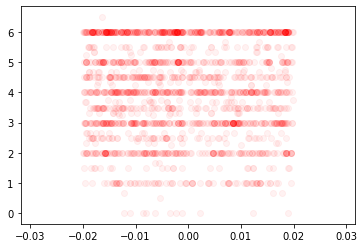

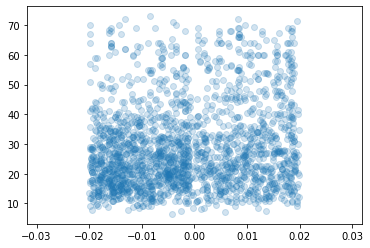

In [37]:

plt.scatter(uruguay['inc_centered'],uruguay['educ'], color = 'r', alpha = 0.05)
plt.show()
plt.scatter(uruguay['inc_centered'],uruguay['age'], alpha = 0.2)
plt.show()

Both graphs report no relationship between income and either age or education. Neither graph shows a discontinuity around the threshold, x = 0, suggesting that the discontinuity in government support plotted against inc_centered is not attributable to either age or education.

In [33]:
results = smf.ols('age ~ in_program * inc_centered', data=uruguay).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     16.22
Date:                Wed, 01 May 2024   Prob (F-statistic):           2.05e-10
Time:                        12:03:19   Log-Likelihood:                -7939.1
No. Observations:                1948   AIC:                         1.589e+04
Df Residuals:                    1944   BIC:                         1.591e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  30.1144      1.027     29.315      0.000      28.100      32.129
in_program                 -1.2710      1.347     -0.944      0.345      -3.912       1.370
inc_centered              142.4408     87.335      1.631      0.103     -28.840     313.722
in_program:inc_centered     5.0176    114.694      0.044      0.965    -219.919     229.954
==============================================================================
Omnibus:                      218.335   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.911
Skew:                           0.941   Prob(JB):                     9.14e-65
Kurtosis:                       3.297   Cond. No.                         499.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The causal estimate of the program on age is -1.271. However, citing the p-value associated with the coefficient (0.345) as well as the large 95% confidence interval encompassing both positive and negative values, we can conclude that the coefficient is statistically insignifcant and that the program has no causal relationship with age (which also makes sense intuitively because a program can not change your age).

In [34]:
results2 = smf.ols('educ ~ in_program * inc_centered', data=uruguay).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3678
Date:                Wed, 01 May 2024   Prob (F-statistic):              0.776
Time:                        12:03:39   Log-Likelihood:                -3498.4
No. Observations:                1897   AIC:                             7005.
Df Residuals:                    1893   BIC:                             7027.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.9677      0.112     35.554      0.000       3.749       4.187
in_program                  0.1077      0.147      0.734      0.463      -0.180       0.396
inc_centered                7.1904      9.463      0.760      0.447     -11.368      25.749
in_program:inc_centered    -8.7748     12.489     -0.703      0.482     -33.268      15.718
==============================================================================
Omnibus:                      225.865   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.957
Skew:                          -0.321   Prob(JB):                     4.82e-20
Kurtosis:                       2.155   Cond. No.                         498.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

5. Verifying Program Enrollment & Income are Causing Discontinuity in Government Support

The causal estimate of the program on education is 0.1077. However, citing the p-value associated with that coefficient (0.463) as well as the large confidence interval encompassing both positive and negative values, we can conclude that the estimate is statistically insignificant as that the program has no causal relationship with education. There is no statistically significant evidence of discontinuities in age or education around the income cutoff, indicating that the causal estimate derived previously from our RD approach is reliable because it proves that the variables, age and education, are not causing the jump and it must then be caused by in_program and inc_centered.